In [5]:
# ! pip install mysql-connector-python

from sqlalchemy import create_engine, text

# SQL flavor, user, password
engineStr = 'mysql+mysqlconnector://___:___' 
engineStr += '@35.202.92.40:3306' # Server Address
engineStr += '/nfl' # Database Name

engine = create_engine(engineStr) 

In [9]:
import pandas as pd

select = """
SELECT
  pbp.DWN as down,
  pbp.TYPE as type,
  pbp.YTG as toGo,
  pbp.YDS AS yards
FROM pbp
JOIN game
  ON pbp.GID = game.GID
WHERE game.SEAS=2019 AND pbp.TYPE IN ("PASS", "RUSH") AND pbp.OFF='SEA';
"""

data = pd.DataFrame(engine.connect().execute(text(select)))

In [10]:
data['pass'] = (data['type']=="PASS")
data['pass'] = data['pass'].astype(int)
# data['success'] = (data['success']=="Y")
# data['success'] = data['success'].astype(int)

In [11]:
data = data[['yards', 'pass', 'down', 'toGo']]

In [12]:
data.to_csv("nfl_pass_rush_success.csv", index=False)

In [ ]:
! pip install pymc3 arviz

In [1]:
import pandas as pd

data = pd.read_csv("nfl_pass_rush_success.csv")

In [2]:
import pymc as pm
import numpy as np

coords = {"observation": data.index.values}

with pm.Model(coords=coords) as binomial_regression_model:
    n = data.shape[0]
    passes = pm.Data("passes", data['pass'], dims="observation")
    down = pm.Data("down", data['down'], dims="observation")
    distance = pm.Data("distance", data['toGo'], dims="observation")
    # priors
    β0 = pm.Normal("β0", mu=0, sigma=1)
    β_pass = pm.Normal("β_pass", mu=0, sigma=1)
    β_down = pm.Normal("β_down", mu=0, sigma=1)
    β_distance = pm.Normal("β_distance", mu=0, sigma=1)
    # linear model
    μ = β0 + β_pass * passes + β_down * down + β_distance * distance
    sigma = pm.HalfNormal("sigma", sigma=5, testval=1.0)
    
    likelihood = pm.Normal("y", mu=μ, sigma=sigma, observed=data['yards'])

    
#     LOGIT CODE
# #     μ = β0 + β_pass * passes 
#     p = pm.Deterministic("p", pm.math.invlogit(μ), dims="observation")
#     # likelihood
#     pm.Binomial("y", n=n, p=p, observed=data["success"], dims="observation")

WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/Users/drwhite/opt/anaconda3/lib/python3.9/site-packages/pymc/data.py:676: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  warnings.warn(
/var/folders/6w/1b39tl99633dxzw1xnnlb_xwvh5cd7/T/ipykernel_73996/2072290937.py:18: FutureWarning: The `testval` argument is deprecated; use `initval`.
  sigma = pm.HalfNormal("sigma", sigma=5, testval=1.0)


In [3]:
with binomial_regression_model:
    #fit the data 
    start=pm.find_MAP()
    step=pm.Metropolis()
    
    #samples from posterior distribution 
    trace=pm.sample(10000, step=step, start=start)

/var/folders/6w/1b39tl99633dxzw1xnnlb_xwvh5cd7/T/ipykernel_73996/1714697192.py:7: FutureWarning: The `start` kwarg was renamed to `initvals` and can now do more. Please check the docstring.
  trace=pm.sample(10000, step=step, start=start)
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [β0]
>Metropolis: [β_pass]
>Metropolis: [β_down]
>Metropolis: [β_distance]
>Metropolis: [sigma]
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 69 seconds.


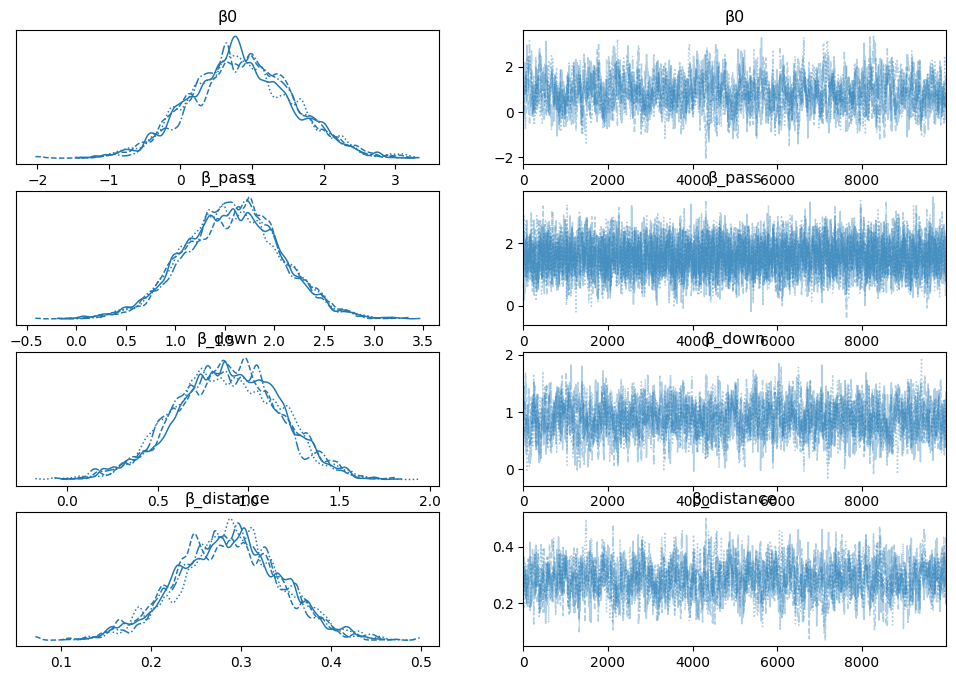

In [4]:
import arviz as az

az.plot_trace(trace, var_names=["β0","β_pass", "β_down", "β_distance"]);

In [5]:
# ! pip install graphviz cachetools

In [6]:
fig = pm.model_to_graphviz(binomial_regression_model)

print(fig.source)

digraph {
	subgraph "clusterobservation (1163)" {
		passes [label="passes
~
ConstantData" shape=box style="rounded, filled"]
		distance [label="distance
~
ConstantData" shape=box style="rounded, filled"]
		down [label="down
~
ConstantData" shape=box style="rounded, filled"]
		label="observation (1163)" labeljust=r labelloc=b style=rounded
	}
	sigma [label="sigma
~
HalfNormal" shape=ellipse]
	"β_down" [label="β_down
~
Normal" shape=ellipse]
	"β_distance" [label="β_distance
~
Normal" shape=ellipse]
	"β_pass" [label="β_pass
~
Normal" shape=ellipse]
	"β0" [label="β0
~
Normal" shape=ellipse]
	subgraph cluster1163 {
		y [label="y
~
Normal" shape=ellipse style=filled]
		label=1163 labeljust=r labelloc=b style=rounded
	}
	sigma -> y
	"β_down" -> y
	passes -> y
	"β_distance" -> y
	"β_pass" -> y
	distance -> y
	"β0" -> y
	down -> y
}



In [7]:
def linear(x_pass, x_down, x_distance, b_pass, b_down, b_distance, b0):
    x = np.array([[1, x_pass, x_down, x_distance]])
    betas = np.array([b0, b_pass, b_down, b_distance]).squeeze()
    return np.dot(x, betas)

b0 = trace.posterior["β0"][0]  # best to make them 1d
b_pass = trace.posterior["β_pass"][0]
b_down = trace.posterior["β_down"][0]
b_distance = trace.posterior["β_distance"][0]

In [8]:
import seaborn as sns

distance = 10

(3.0, 8.0)

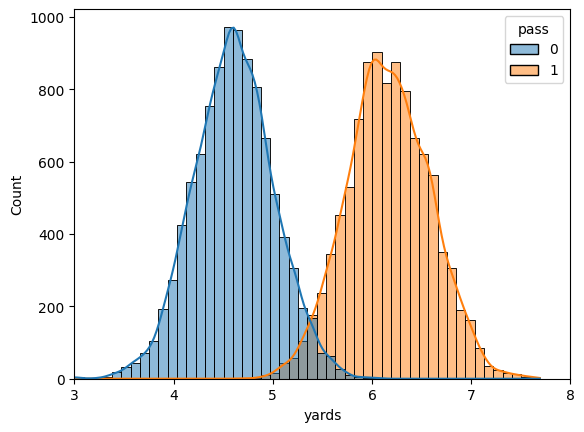

In [9]:
prob_pass1 = linear(1, 1, distance, b_pass, b_down, b_distance, b0)
prob_pass1 = pd.DataFrame(prob_pass1.T, columns =['yards'])
prob_pass1['pass'] = 1

prob_run1 = linear(0, 1, distance, b_pass, b_down, b_distance, b0)
prob_run1 = pd.DataFrame(prob_run1.T, columns =['yards'])
prob_run1['pass'] = 0

prob = pd.concat([prob_pass1, prob_run1], axis=0).reset_index(drop=True)

plt = sns.histplot(data=prob, x="yards", hue="pass", kde=True, bins=50)
plt.set_xlim(3,8)

(3.0, 8.0)

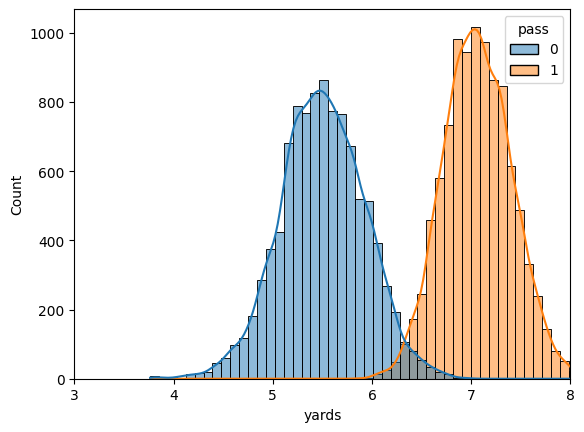

In [11]:
prob_pass2 = linear(1, 2, distance, b_pass, b_down, b_distance, b0)
prob_pass2 = pd.DataFrame(prob_pass2.T, columns =['yards'])
prob_pass2['pass'] = 1

prob_run2 = linear(0, 2, distance, b_pass, b_down, b_distance, b0)
prob_run2 = pd.DataFrame(prob_run2.T, columns =['yards'])
prob_run2['pass'] = 0

prob2 = pd.concat([prob_pass2, prob_run2], axis=0).reset_index(drop=True)

plt = sns.histplot(data=prob2, x="yards", hue="pass", kde=True, bins=50)
plt.set_xlim(3,8)

(3.0, 8.0)

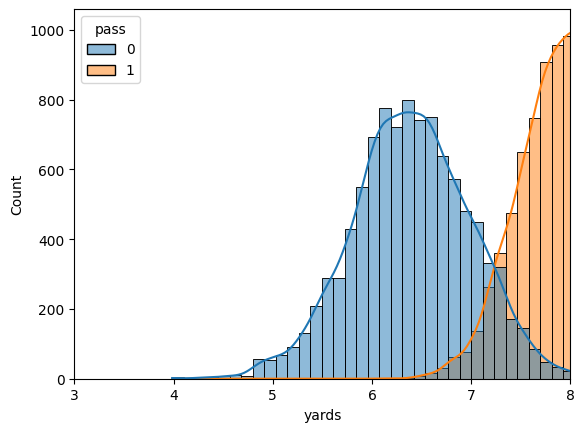

In [12]:
prob_pass3 = linear(1, 3, distance, b_pass, b_down, b_distance, b0)
prob_pass3 = pd.DataFrame(prob_pass3.T, columns =['yards'])
prob_pass3['pass'] = 1

prob_run3 = linear(0, 3, distance, b_pass, b_down, b_distance, b0)
prob_run3 = pd.DataFrame(prob_run3.T, columns =['yards'])
prob_run3['pass'] = 0

prob3 = pd.concat([prob_pass3, prob_run3], axis=0).reset_index(drop=True)

plt = sns.histplot(data=prob3, x="yards", hue="pass", kde=True, bins=50)
plt.set_xlim(3,8)

(3.0, 8.0)

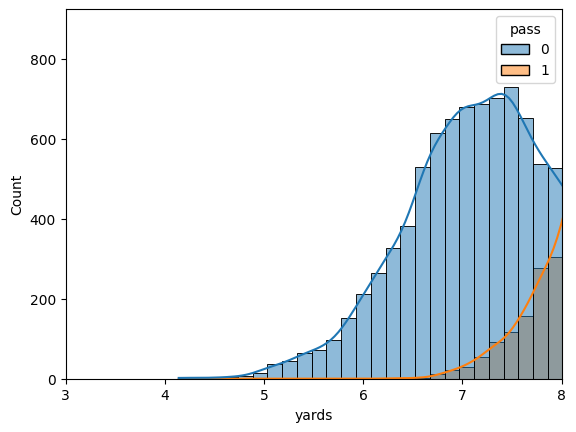

In [13]:
prob_pass4 = linear(1, 4, distance, b_pass, b_down, b_distance, b0)
prob_pass4 = pd.DataFrame(prob_pass4.T, columns =['yards'])
prob_pass4['pass'] = 1

prob_run4 = linear(0, 4, distance, b_pass, b_down, b_distance, b0)
prob_run4 = pd.DataFrame(prob_run4.T, columns =['yards'])
prob_run4['pass'] = 0

prob4 = pd.concat([prob_pass4, prob_run4], axis=0).reset_index(drop=True)

plt = sns.histplot(data=prob4, x="yards", hue="pass", kde=True, bins=50)
plt.set_xlim(3,8)

In [14]:
np.mean([i>j for i, j in zip(list(prob_pass4['yards'].values), list(prob_run4['yards'].values))])*100

99.98